In [1]:
# this file collects all results for 8k, under 4 read out modes, up to cls=7 or 10.

In [2]:
from os.path import join, dirname, exists
from os import makedirs
from itertools import chain
from thesis_v2 import dir_dict

In [3]:
import pandas as pd

In [4]:
def load_data():
    ret = pd.read_pickle(
                join(dir_dict['analyses'], 'tang_refactored', '20201215', 'main_result_separatebn.pkl')
    ).sort_index()
    assert ret.index.is_unique
    return ret.dropna()

In [5]:
def load_main_results():
    # take main results and compare
    ret = pd.read_pickle(
        join(dir_dict['analyses'], 'tang_refactored', '20201002', 'main_result_0,500.pkl')
    )
    ret2 = pd.read_pickle(
        join(dir_dict['analyses'], 'tang_refactored', '20201018', 'main_result_0,500.pkl')
    )
    ret = pd.concat([ret, ret2], axis=0)
    del ret2
    assert ret.index.is_unique
    return ret.dropna()

In [6]:
df_main_result_ref = load_main_results()
df_main_result = load_data()



In [7]:
df_main_result_ref.index.get_level_values('rcnn_bl_cls').isin(range(2,8)).sum()

6912

In [8]:
aaaa = df_main_result_ref.join(df_main_result.dropna(), how='inner', lsuffix='_ref', rsuffix='_new').sort_index()

In [9]:
aaaa

cc2_normed_avg_ref  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                       
relu     False                mse       0          2         8           2           cm-avg       350                   0.265808   
                                                                                                  700                   0.343502   
                                                                                                  1400                  0.416694   
                                                                                     cm-last      350                   0.316284   
                                                                                                  700                   0.392453   
...                                                                                                                          ...   
softplus True                 poisson   1          3         32          4           inst-avg     700                   0.443568   
                                                                                                  1400                  0.492293   
                                                                                     inst-last    350                   0.362679   
                                                                                                  700                   0.410910   
                                                                                                  1400                  0.476128   

                                                                                                              cc2_raw_avg_ref  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                    
relu     False                mse       0          2         8           2           cm-avg       350                0.247617   
                                                                                                  700                0.320437   
                                                                                                  1400               0.387653   
                                                                                     cm-last      350                0.294557   
                                                                                                  700                0.365289   
...                                                                                                                       ...   
softplus True                 poisson   1          3         32          4           inst-avg     700                0.412067   
                                                                                                  1400               0.456695   
                                                                                     inst-last    350                0.337775   
                                                                                                  700                0.381652   
                                                                                                  1400               0.441330   

                                                                                                              cc_raw_avg_ref  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                   
relu     False                mse       0          2         8           2           cm-avg       350               0.458852   
                                                                                                  700               0.524848   
                                                                                                  1400              0.588275   
                                                                           

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from thesis_v2.plots.basic import scatter
from thesis_v2.plots.util import savefig

In [11]:
from scipy.stats import pearsonr, spearmanr

350
350
700
700
1400
1400


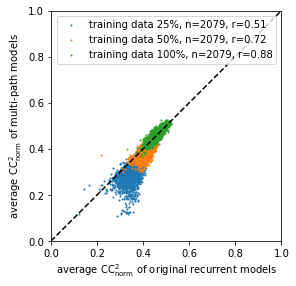

In [12]:
def plot_scatter():
    # check performance diff between two readout types
    plt.close('all')
    fig, ax = plt.subplots(squeeze=True, figsize=(4,4))
    training_data_mapping = {
        350: '25%',
        700: '50%',
        None: '100%',
        1400: '100%',
    }
    # this does NOT sort.
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.unique.html
    # you need to sort the dataframe before, fo
    for train_keep in aaaa.index.get_level_values('train_keep').unique():
        print(train_keep)
        b = aaaa.xs(train_keep, level='train_keep')
        n = b.shape[0]
        r = pearsonr(b['cc2_normed_avg_ref'].values, b['cc2_normed_avg_new'].values)[0]
        ax.scatter(b['cc2_normed_avg_ref'].values, b['cc2_normed_avg_new'].values, s=1,
                   label='training data {}, n={}, r={:.2f}'.format(
                       training_data_mapping[train_keep], n, r
                   )
                  )
        
        # compute pearson
        print(train_keep)
        
        
    ax.set_xlabel('''average ${\\mathrm{CC}}_{\\mathrm{norm}}^2$ of original recurrent models''')
    ax.set_ylabel('''average ${\\mathrm{CC}}_{\\mathrm{norm}}^2$ of multi-path models''')
    ax.plot([0,1],[0,1],linestyle='--',color='k')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.legend()
    
    pltdir = join(dir_dict['plots'], 'tang_refactored', '20201215')
    makedirs(pltdir, exist_ok=True)
    fig.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
    savefig(fig, join(pltdir, 'multi_vs_r.pdf'))
    
    plt.show()
    
    

    
plot_scatter()

# more channels lead to higher correlation.
# which is kind of expected, because deep + thin leads to bad convergence properties.
# why -last performed worse than -avg: probably because there is more supervision in -avg during training.
# -avg training is used in K's paper
